In [1]:
# !pip isntall -r requirements.txt

In [2]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from torchmetrics import StructuralSimilarityIndexMeasure


import importlib
import config
import os
import datetime
import math

importlib.reload(config)
# from datasets import load_dataset

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\kuzga\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\kuzga\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


<module 'config' from 'c:\\Users\\kuzga\\OneDrive\\Рабочий стол\\ShiftLab-2024-Computer-Vision\\config.py'>

In [3]:
# Выбираем cpu в качестве устройства, так как такие маленькие модели на CUDA обучаются дольше.
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
print(f"Device is {device}")

Device is cuda


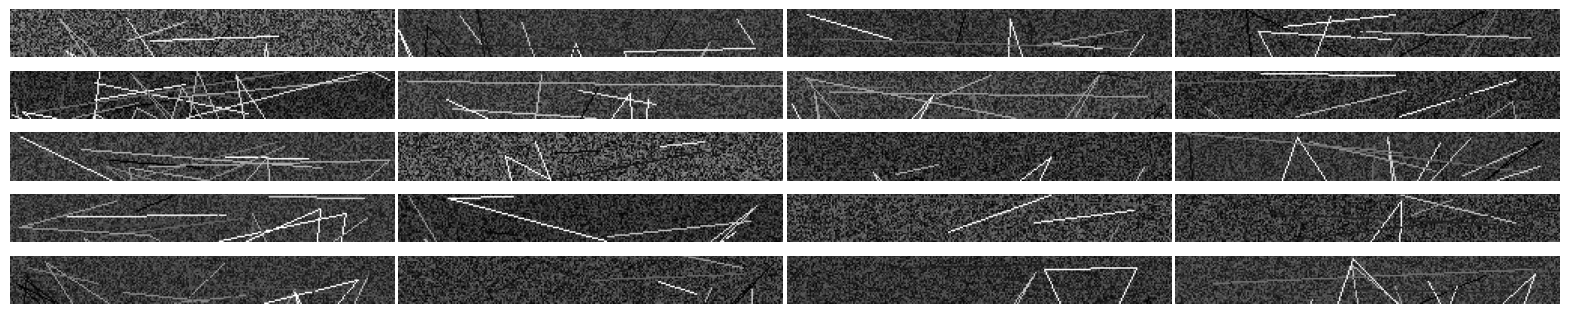

In [4]:
def create_noisy_image(width=256, height=32, min_noise=20, max_noise=100, min_lines=4, max_lines=25, curve_probability=0.8):
    """
    Создает одноканальное изображение с шумным фоном, на котором рисуются прямые и кривые линии разного цвета.

    Args:
        width : int
            Ширина изображения (по умолчанию 256).
        height : int
            Высота изображения (по умолчанию 32).
        min_noise: int
            Минимальное значение цвета в шуме.
        max_noise: int
            Максимальное значение цвета в шуме.
        min_lines : int
            Минимальное количество линий, которые будут нарисованы (по умолчанию 4).
        max_lines : int
            Максимальное количество линий, которые будут нарисованы (по умолчанию 25).
        curve_probability : float
            Вероятность, что линия будет кривой (по умолчанию 0.8, диапазон от 0 до 1).

    Returns:
        numpy.ndarray
            Созданное одноканальное изображение с шумом и линиями.
    """
    noisy_img = np.random.uniform(min_noise, max_noise, (height, width)).astype(np.uint8)

    if max_lines != 0:
        line_count = random.randint(min_lines, max_lines)
        for _ in range(line_count):
            color = np.random.randint(0, 256)  # Цвет в градациях серого
            if np.random.rand() < curve_probability:
                # Рисуем кривую
                points = np.random.randint(0, width, size=(5, 2))
                points = points.reshape((-1, 1, 2))  # Приводим к нужному формату для polylines
                cv2.polylines(noisy_img, [points], isClosed=False, color=color, thickness=1)
            else:
                # Рисуем прямую линию
                pt1 = (np.random.randint(0, width), np.random.randint(0, height))
                pt2 = (np.random.randint(0, width), np.random.randint(0, height))
                cv2.line(noisy_img, pt1, pt2, color, thickness=1)

    return noisy_img

# Генерация изображений
noisy_images = [create_noisy_image() for _ in range(20)]

# Визуализация
plt.figure(figsize=(20, 4))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(noisy_images[i], cmap='gray')  # Используем серую цветовую карту
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

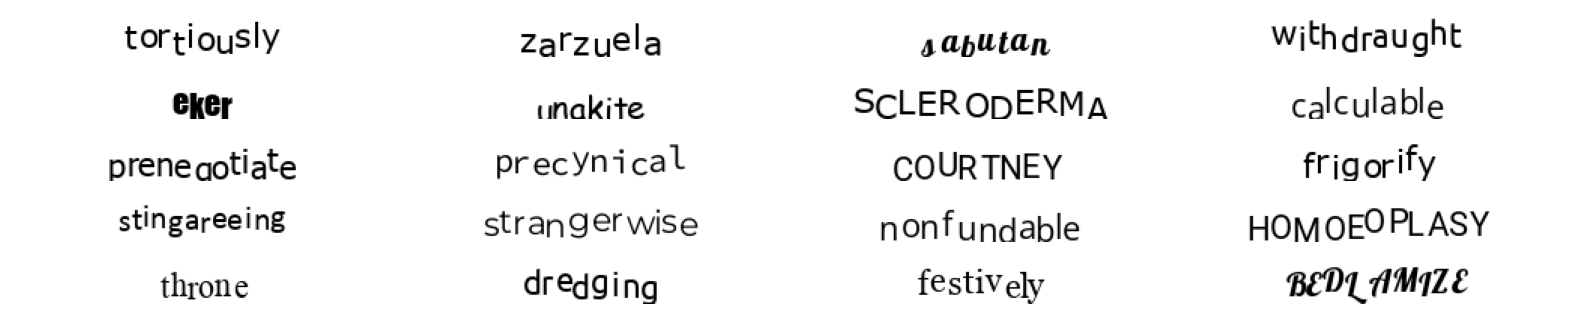

In [5]:
def generate_text_image(text=None, size=(32,256), img=None, max_char_y_offset=0.15, max_char_x_offset=0.1):
    if text is None:
        text = random.choice(config.texts)

    if img is None:
        img = np.ones(size, dtype=np.uint8) * 255

    font_path = random.choice(config.fonts_paths)
    font_size = math.floor(size[0] * 0.6)
    font = ImageFont.truetype(font_path, font_size)

    pil_img = Image.fromarray(img, mode='L')
    draw = ImageDraw.Draw(pil_img)

    # Находим позицию текста
    bbox = draw.textbbox((0, 0), text, font=font)
    text_size = (bbox[2] - bbox[0], bbox[3] - bbox[1])

    # Уменьшаем размер шрифта, если текст не помещается
    while text_size[0] >= img.shape[1] or text_size[1] > img.shape[0]:
        font_size -= 1
        font = ImageFont.truetype(font_path, font_size)
        bbox = draw.textbbox((0, 0), text, font=font)
        text_size = (bbox[2] - bbox[0], bbox[3] - bbox[1])

    text_x = (img.shape[1] - text_size[0]) // 2
    text_y = (img.shape[0] - text_size[1]) // 2

    # Рисуем текст с небольшими случайными смещениями
    for char in text:
        bbox = draw.textbbox((text_x, text_y), char, font=font)
        char_width = bbox[2] - bbox[0]
        char_height = bbox[3] - bbox[1]

        x_offset = random.randint(int(-char_width * max_char_x_offset), int(char_width * max_char_x_offset))
        y_offset = random.randint(int(-char_height * max_char_y_offset), int(char_height * max_char_y_offset))
        draw.text((text_x + x_offset, text_y + y_offset), char, font=font, fill=0)  # Черный текст

        text_x += char_width  # Сдвигаем на ширину текущей буквы

    return np.array(pil_img)  # Преобразуем обратно в NumPy массив


images = [generate_text_image() for _ in range(20)]
plt.figure(figsize=(20, 4))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

In [6]:
num_epochs = 100
batch_size = 64
learning_rate = 0.0001

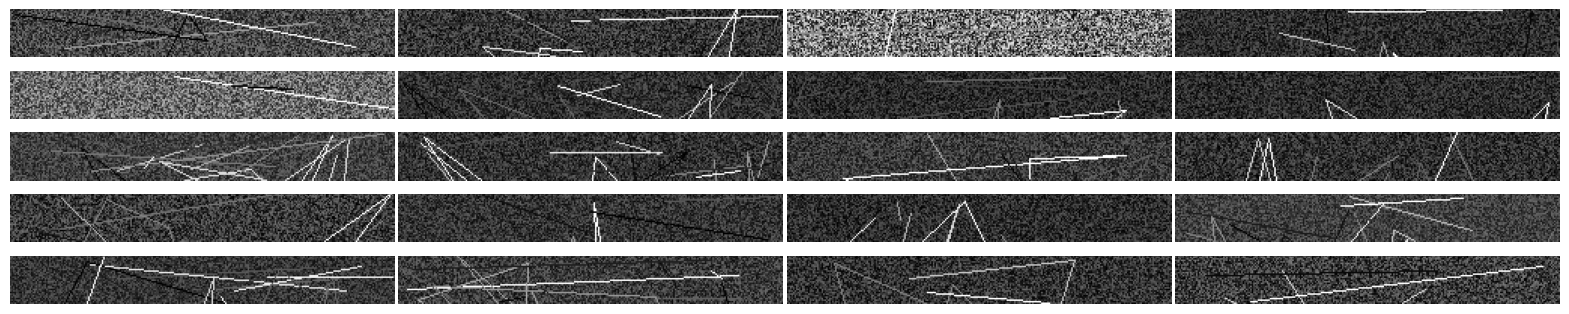

In [7]:
class NoisyImageDataset(Dataset):
    def __init__(self, num_samples=1000):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = create_noisy_image()
        return transforms.ToTensor()(image)


dataset = NoisyImageDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

noisy_images = next(iter(dataloader))
plt.figure(figsize=(20, 4))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(noisy_images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 4096),
            nn.ReLU(),
            nn.Linear(4096, 8192),
            nn.ReLU(),
            nn.Linear(8192, 32 * 256),
            nn.Tanh()
        )

    def forward(self, z, text=None):
        noise = self.model(z).view(-1, 1, 32, 256)
        if text is not None:
            combined_images = []
            for i in range(batch_size):
                text_img = generate_text_image()
                text_img = torch.tensor(text_img, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
                combined = noise[i:i+1] * 0.5 + text_img * 0.5
                combined_images.append(combined)

            return torch.cat(combined_images, dim=0)
        return noise


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(32 * 256, 4096),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(4096, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(-1, 1 * 32 * 256))

Epoch [53/100] Avg Loss D: 1.3603294491767883, Avg Loss G: 0.7241895794868469, Avg MSE: 0.027063537389039993, Avg SSIM: 0.06568243354558945


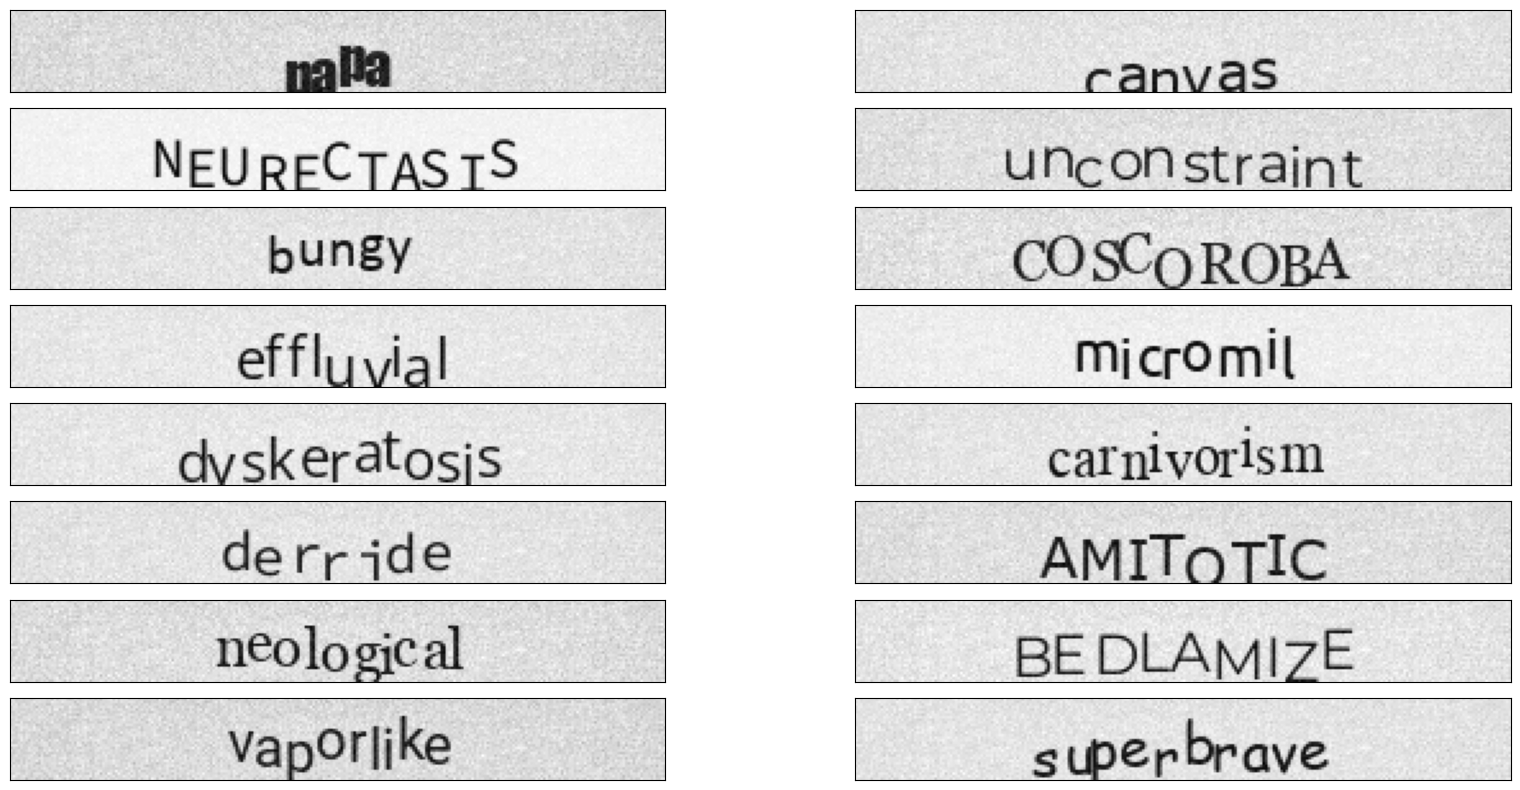

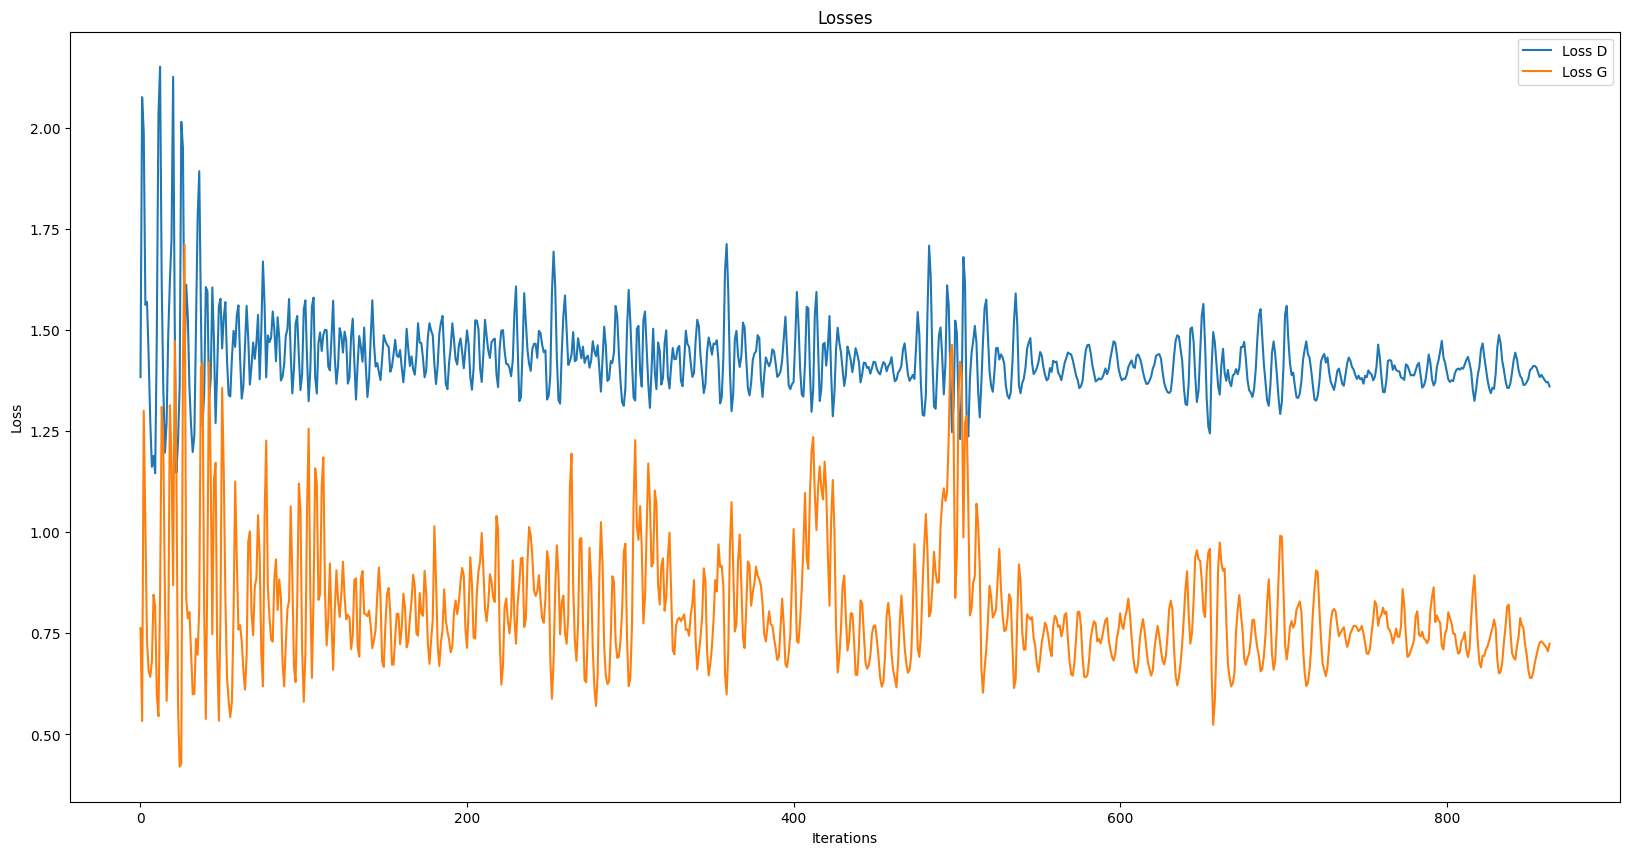

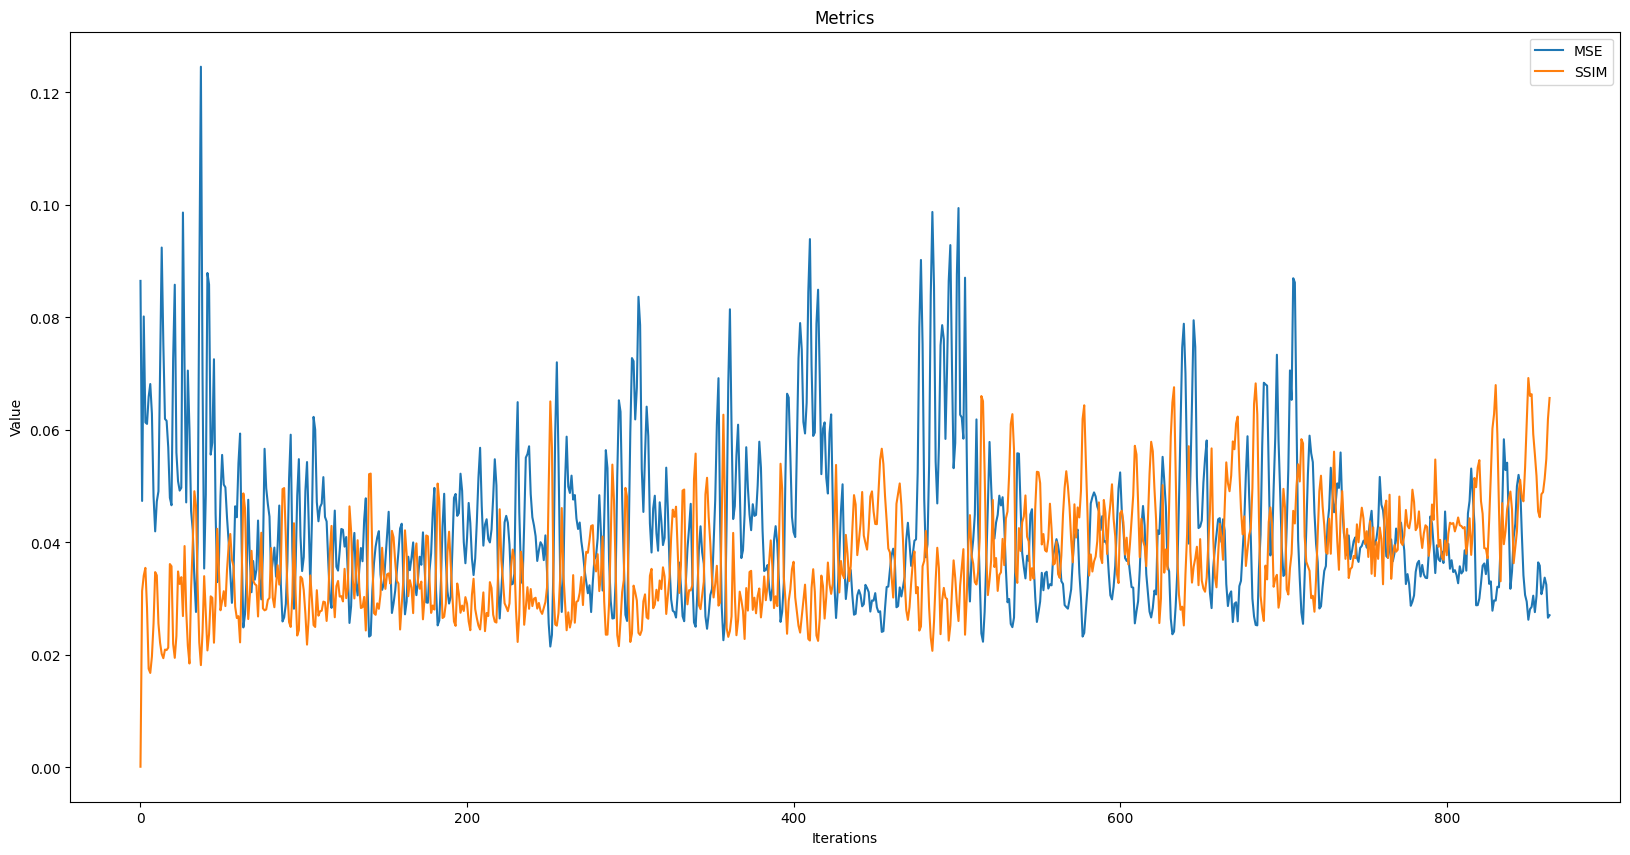

In [ ]:
num_epochs = 100
batch_size = 64
n_display = 1
dataset = NoisyImageDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Для хранения лоссов и метрик
d_losses = []
g_losses = []
mse_values = []
ssim_values = []

ssim_metric = StructuralSimilarityIndexMeasure()

for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator
        optimizer_d.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        z = torch.randn(batch_size, 1000)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

        # Сохраняем потери
        d_losses.append(d_loss_real.item() + d_loss_fake.item())
        g_losses.append(g_loss.item())

        # Рассчитываем MSE и SSIM
        mse = nn.MSELoss()(fake_images.view(batch_size, -1), real_images.view(batch_size, -1)).item()
        mse_values.append(mse)

        ssim = ssim_metric(fake_images, real_images)
        ssim_values.append(ssim.item())

    if (i + 1) % n_display == 0:
        clear_output(True)

        avg_d_loss = sum(d_losses[-n_display:]) / n_display
        avg_g_loss = sum(g_losses[-n_display:]) / n_display
        avg_mse = sum(mse_values[-n_display:]) / n_display
        avg_ssim = sum(ssim_values[-n_display:]) / n_display

        print(f"Epoch [{epoch}/{num_epochs}] Avg Loss D: {avg_d_loss}, Avg Loss G: {avg_g_loss}, Avg MSE: {avg_mse}, Avg SSIM: {avg_ssim}")

        fake_images = generator(z, True).cpu().detach()

        plt.figure(figsize=(20, 10))
        for i in range(16):
            ax = plt.subplot(8, 2, i + 1)
            plt.imshow(fake_images[i].squeeze(0), cmap='gray')
            plt.xticks([])
            plt.yticks([])
        # plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

        # Визуализация потерь и метрик
        plt.figure(figsize=(20, 10))
        plt.plot(d_losses, label='Loss D')
        plt.plot(g_losses, label='Loss G')
        plt.title('Losses')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.plot(mse_values, label='MSE')
        plt.plot(ssim_values, label='SSIM')
        plt.title('Metrics')
        plt.xlabel('Iterations')
        plt.ylabel('Value')
        plt.legend()
        plt.show()